# Esercitazione 8
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione otto è raccolto nella cartella `Lab_08`. I codici si trovano nelle cartelle `Code/8.1, 8.2, 8.3`, corrispondenti agli esercizi assegnati. I risultati sono invece raccolti nella cartella `Results`.

---

Questo Jupyter Notebook è organizzato nel modo seguente:
- 8.0 caricamento dei pacchetti e introduzione;
- 8.1 costruzione di un codice _Variational Monte Carlo_ (VMC);
- 8.2 ottimizzazione dei parametri per la stima $\langle H \rangle_T$;
- 8.3 studio dello stesso sistema quantistico con metodi PIMC/PIGS.

## 8.0 - caricamento dei pacchetti e introduzione

L'algoritmo di Metropolis può essere utilizzato per stimare i valori d'aspettazione di interesse in sistemi quantistici, in questo caso siamo interessati particolarmente al valore di aspettazione dell'hamiltoniana $\langle \hat{H} \rangle$ al _ground state_ (GS) di una particella quantistica 1D confinata nel potenziale:

$$ V(x)= x^4- \frac{5}{2} x^2.$$

---

In primo luogo assumiamo si conoscere la forma analitica della funzione d'onda, che chiamiamo $\Psi(x|\vec{\beta})$, dove $\vec{\beta}$ è un vettore contenente i parametri della funzione d'onda. In questo caso consideriamo una funzione del tipo:

$$
\Psi(x|\sigma, \mu) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$

dove $\mu$ e $\sigma$ sono i due componenti del vettore dei parametri. Il _Variational Principle_ afferma che, scelta una forma analitica per la funzione d'onda dipendente da alcuni parametri variazionali è possibile ottenere un limite superiore alla stima dell'energia media di GS (il cui valore vero è $E_0$) minimizzando la seguente espressione:

$$ E(\vec{\beta})= \frac{\int dx \Psi(x|\vec{\beta})^*\, H\, \Psi(x|\vec{\beta})}{\int dx |\Psi(x|\vec{\beta})|^2} \geq E_0.$$ 



In secondo luogo, sappiamo che tramite $M(RT)^2$ è possibile campionare la regione di spazio di interesse con un certo numero di passi (chiamo $x_i$ la posizione occupata dal _walker_ al passo $i$-esimo). Per rendere utile al problema tale procedura imponiamo che la distribuzione di probabilità che governa il campionamento del Metropolis sia $|\Psi(x|\vec{\beta})|^2$. A questo punto, a ciascun passo dell'algoritmo corrisponde una configurazione del sistema, in cui è possibile calcolare il valore locale dell'energia $E_L(x_i)$. Una volta raccolti tutti i valori, l'energia del sistema può essere stimata nel modo seguente:

$$ E_T = \frac{1}{N_{step}}\sum_i E_L(x_i), \qquad \text{con}\qquad E_L(x_i)=\frac{\hat{H}\Psi(x_i|\vec{\beta})}{\Psi(x_i|\vec{\beta})} .$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sns.set_theme(font_scale=1.7, style='whitegrid') 

In [120]:
sample = np.loadtxt("Code/8.1/sampling.dat")
energy = np.loadtxt("Code/8.1/ene.dat")
anneal = np.loadtxt("Results/show_annealing.dat")
par_hi = np.loadtxt("Results/par_history.dat")

In [121]:
taus = [0, 2, 5, 8, 10]
labels = [r'$\tau=0$', r'$\tau=2$',r'$\tau=5$',r'$\tau=8$',r'$\tau=10$']

posi_pigs = []
prob_pigs = []

for i in range(5):
    temporary_ds = np.loadtxt("Code/8.3/probability_"+str(taus[i])+".dat")
    posi_pigs.append(temporary_ds.T[0])
    prob_pigs.append(temporary_ds.T[1])

## 8.1 - Costruzione del codice VMC

__NB:__ nel corso dell'esercitazione ho adottato $\hbar = 1 = m$.

---

In questo primo punto dell'esercitazione costruiamo un codice che ci permetta di effettuare un campionamento (e una stima) fissando il vettore dei parametri nella funzione d'onda. La struttura del codice assomiglia a quella proposta nell'esercizio sei e nel sette. 

La singola mossa di Metropolis, descritta nel metodo `Move` viene proposa a partire da un passo estratto da una distribuzione uniforme $\mathcal{U}[0, \text{stepsize})$ (azione del nucleo stocastico $T$). La probabilità di accettazione di tale mossa viene calcolata come:
$$ \alpha = A(x\to x') = \min \biggl(1, \frac{p(x')}{p(x)} \biggr), $$
con $p(x)$ implementata, come detto in precedenza, come sovrapposizione di due gaussiane centrate rispettivamente in $\pm \mu$ e di varianza $\sigma^2$. 

Una volta ottenuta la nuova configurazione, viene effettuata la misura. Nel codice ho eseguito tale procedimento in questo modo: `walker[ie] = apply_H(x) + eval_V(x)`, dove nei due metodi esposti calcolo i contributi all'energia dovuti rispettivamente all'azione dell'hamiltoniana sulla funzione d'onda e del potenziale, entrambi valutati in $x$. Per implementare il metodo `apply_H(x)` ho risolto analiticamente 

$$
\frac{{-\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}.
$$

In questa prima parte dell'esercitazione ho anche effettuato una stima dell'energia del sistema $\langle \hat{H} \rangle_T$ utilizzando il metodo delle medie a blocchi.

---

I risultati riportati nei grafici seguenti sono stati ricavati da una _run_ nella quale ho impostato $\mu=0.8$ e $\sigma=0.62$. Tali valori sono gli stessi estratti dall'analisi svolta nell'esercizio 8.2. Ho eseguito la misura tramite _blocking_ utilizzando $N=100$ blocchi $M=10^4$ passi per ciascun blocco. 

In [122]:
mu = 0.8
sigma = 0.62

def Vpot(x):
    return (x**2-2.5)*x**2

def Analitic_psi(x,mu,sigma):  #è il modulo quadro della psi di trial normalizzata
    normalization = 2. * sigma * np.sqrt(np.pi) * ( 1. + np.exp(-mu**2/sigma**2) )
    return ((np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))**2)/normalization

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

E,psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

scale = 0.3


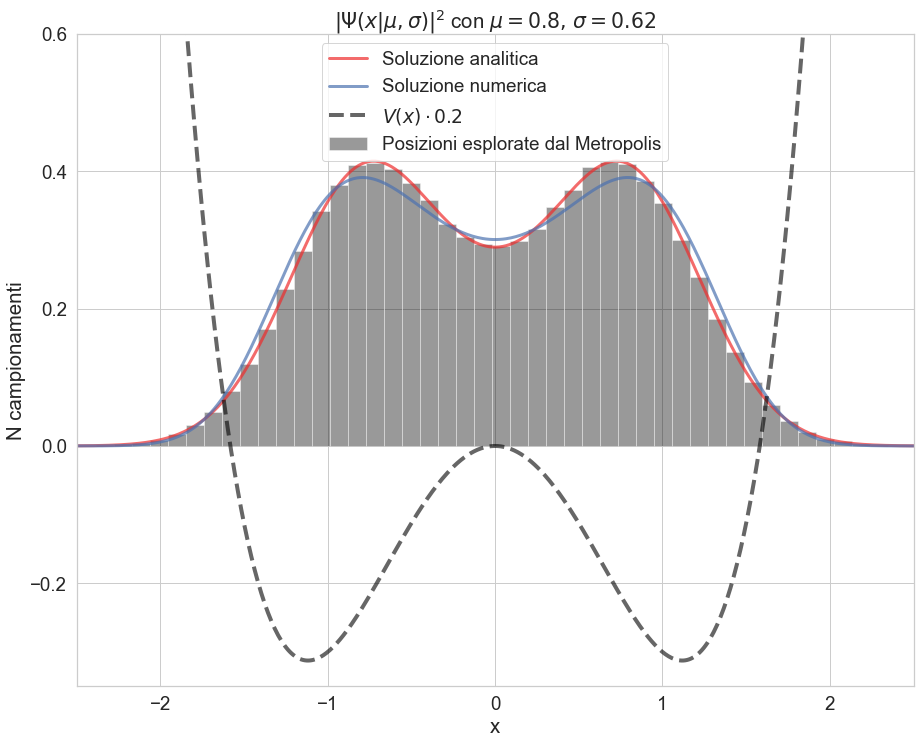

In [123]:
plt.figure(figsize=(15,12))
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.8,\, \sigma=0.62$')
plt.hist(sample, bins=50, density=True, alpha=0.4, color='black', label='Posizioni esplorate dal Metropolis')
plt.plot(x, Analitic_psi(x, mu, sigma), color='#EE2C2C', linewidth=3, alpha=0.7, label='Soluzione analitica')
plt.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=3, alpha=0.7)
plt.plot(x, Vpot(x)*0.2, color='black', linewidth=4, alpha=0.6, linestyle='--', label=r'$V(x)\cdot 0.2$')
plt.ylim(-0.35,0.6)
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('N campionamenti')
plt.legend()
plt.show()

__Figura 1:__ istogramma relativo alle posizioni campionate tramite Metropolis. Mettiamo a confronto il risultato dell'algoritmo di VMC con le soluzioni analitica e numerica calcolate con lo script python presentato nella cella precedente ottenute utilizzando gli stessi parametri con i quali ho eseguito il codice VMC.

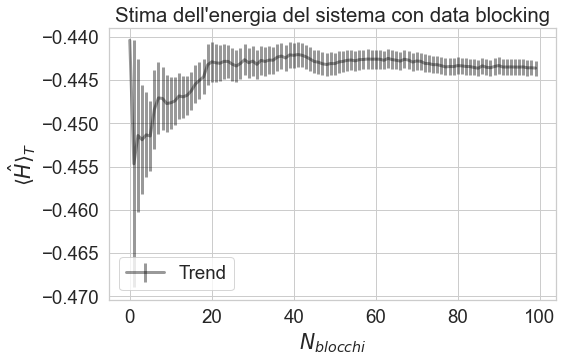

In [124]:
xx = np.arange(100)

plt.figure(figsize=(8,5))
plt.title("Stima dell'energia del sistema con data blocking")
plt.errorbar(xx, energy.T[2], yerr=energy.T[3], color='black', alpha=0.4, label='Trend', linewidth=3)
#plt.hlines(e,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
plt.ylabel(r'$\langle \hat{H} \rangle_T$')
plt.xlabel("$N_{blocchi}$")
plt.legend()
plt.show()

## 8.2 - ottimizzazione dei parametri

Per scegliere in modo intelligente i parametri $\mu, \sigma$ ho implementato un metodo, `simulated_annealing(betai, betaf, Nstep)`, all'interno del quale ho eseguito una ricerca della configurazione del $\vec{\beta}$ ottimale in accordo con l'omonimo algoritmo (SA). In un algoritmo di SA si imposta una temperatura fittizia iniziale (o, analogamente, un $\beta = 1/T$) e si inizia a sottoporre il sistema ad una serie di modifiche con l'intenzione di migliorare una performance (nel nostro caso variamo la configurazione dei due parametri $\mu$ e $\sigma$ con l'intento di trovare delle combinazioni con cui si può ottenere una stima del valor medio dell'hamiltoniana il più basso possibile). L'algoritmo viene eseguito raffreddando sempre di più il sistema e consentendo, perciò, modifiche sempre meno probabili alla configurazione ottenuta fino a quel momento. 

---


Le condizioni iniziali con cui ho avviato la ricerca della soluzione ottimale sono:

$$ \mu=1, \qquad \sigma = 1, $$

che ho scelto osservando la forma del potenziale.

Ho eseguito un totale di `Nstep = 1'000` passi, tramite cui ho raffreddato il sistema passando da `betai = 1` a `betaf = 1000`. I valori finali che ho ottenuto per i parametri sono: 

$$ \mu \simeq 0.81, \qquad \sigma \simeq  0.62.$$

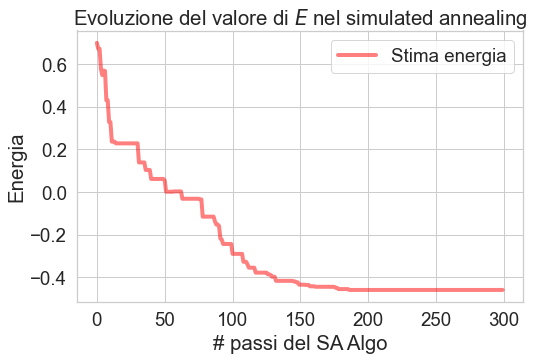

Configurazione ottimale raggiunta: mu, sigma = 0.811425 ,  0.619531


In [128]:
plt.figure(figsize=(8,5))
plt.title('Evoluzione del valore di $E$ nel simulated annealing')
plt.plot(anneal, linewidth=4, alpha=0.5, color='red', label='Stima energia')
plt.legend()
plt.xlabel('# passi del SA Algo')
plt.ylabel('Energia')
plt.show()
#for i in range(len(par_hi)):
#    plt.text(700, 1-i*0.2 , pars[i], bbox=dict(facecolor='red', alpha=0.3))
#    plt.hlines(en_values[i],0,1000, linestyle='--')
print(r'Configurazione ottimale raggiunta: mu, sigma =', 0.811425, ", ", 0.619531)

In [119]:
path    = 'Code/8.3/'
taus    = [1,2,5,8]
color   = ['orange', 'red', 'purple', 'blue']
markers = ['o', 's', '^', 'P']

pigs_x = []
pigs_p = []
pigs_e = []

names   = []
files   = []

for i in range(len(taus)):
    names.append(r'$\Psi$ costante, $\tau$='+str(taus[i]))
    files.append('wf_const_'+str(taus[i])+'.dat')
    pigs_x.append(np.loadtxt(path+files[i]).T[0])
    pigs_p.append(np.loadtxt(path+files[i]).T[1])
    pigs_e.append(np.loadtxt(path+files[i]).T[2])

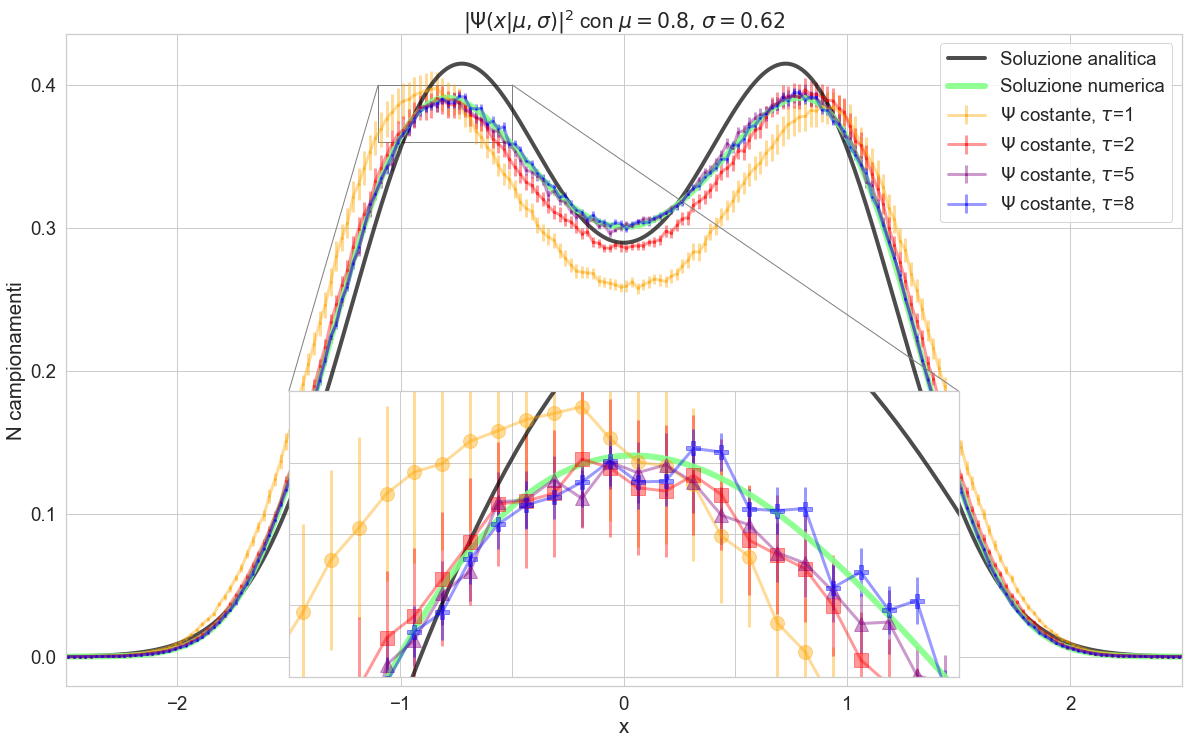

In [120]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.8,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('N campionamenti')

axins=zoomed_inset_axes(ax,5,loc=8)   
x1, x2, y1, y2 = -1.1, -0.5, 0.36, 0.40
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
axins.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(len(files)):
    ax.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
    axins.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=14)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')
axins.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')


ax.legend(loc=1)
plt.show()

In [152]:
path    = 'Code/8.3/'
taus    = [1,2,5,8]
color   = ['orange', 'red', 'purple', 'blue', 'green']
markers = ['o', 's', '^', 'P', '*']

pigs_x = []
pigs_p = []
pigs_e = []

names   = []
files   = []

for i in range(len(taus)):
    names.append(r'$\Psi$ var, $\tau$='+str(taus[i]))
    files.append('wf_var_'+str(taus[i])+'.dat')
    pigs_x.append(np.loadtxt(path+files[i]).T[0])
    pigs_p.append(np.loadtxt(path+files[i]).T[1])
    pigs_e.append(np.loadtxt(path+files[i]).T[2])

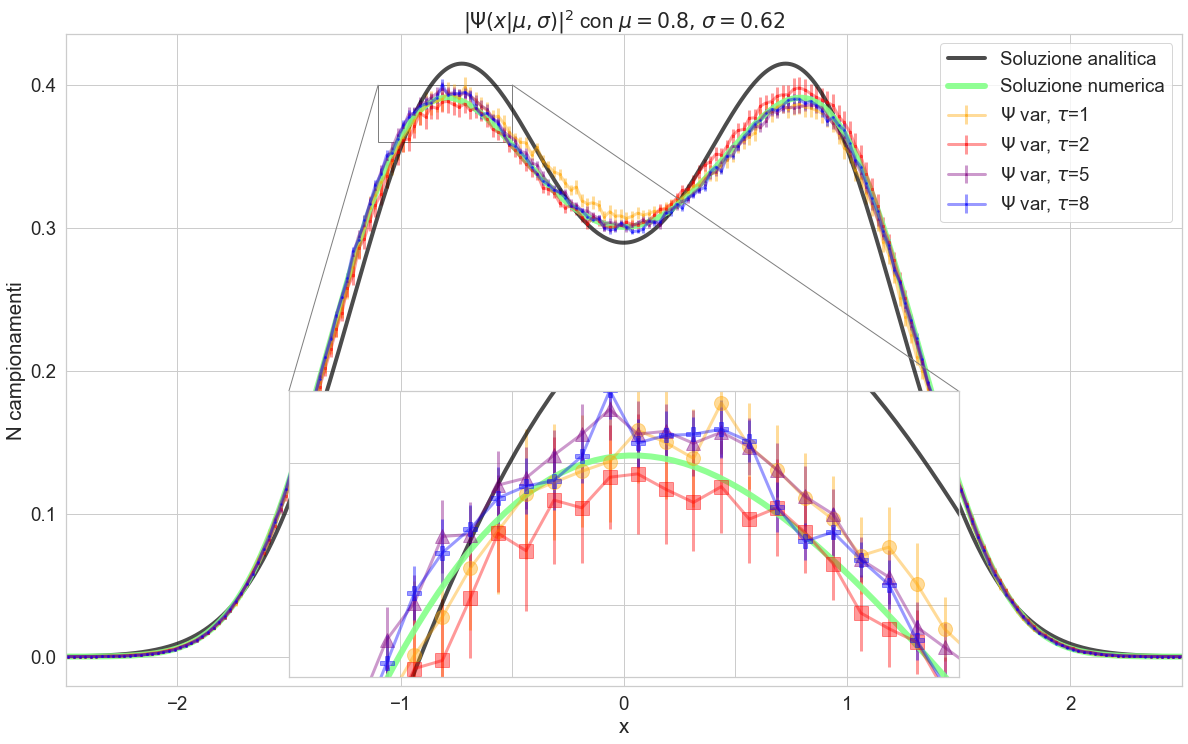

In [153]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.8,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('N campionamenti')

axins=zoomed_inset_axes(ax,5,loc=8)   
x1, x2, y1, y2 = -1.1, -0.5, 0.36, 0.40
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
axins.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(len(files)):
    ax.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
    axins.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=14)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')
axins.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')


ax.legend(loc=1)
plt.show()

In [154]:
T = ['0.1', '0.25', '1.25', '5', '5.0']
labels = ['T=0.1', 'T=0.25', 'T=1.25', 'T=5.0, acc=0.6', 'T=5.0, acc=0.97']

pimc_x = []
pimc_p = []
pimc_e = []

for i in range(len(T)):
    pimc_x.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[0])
    pimc_p.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[1])
    pimc_e.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[2])

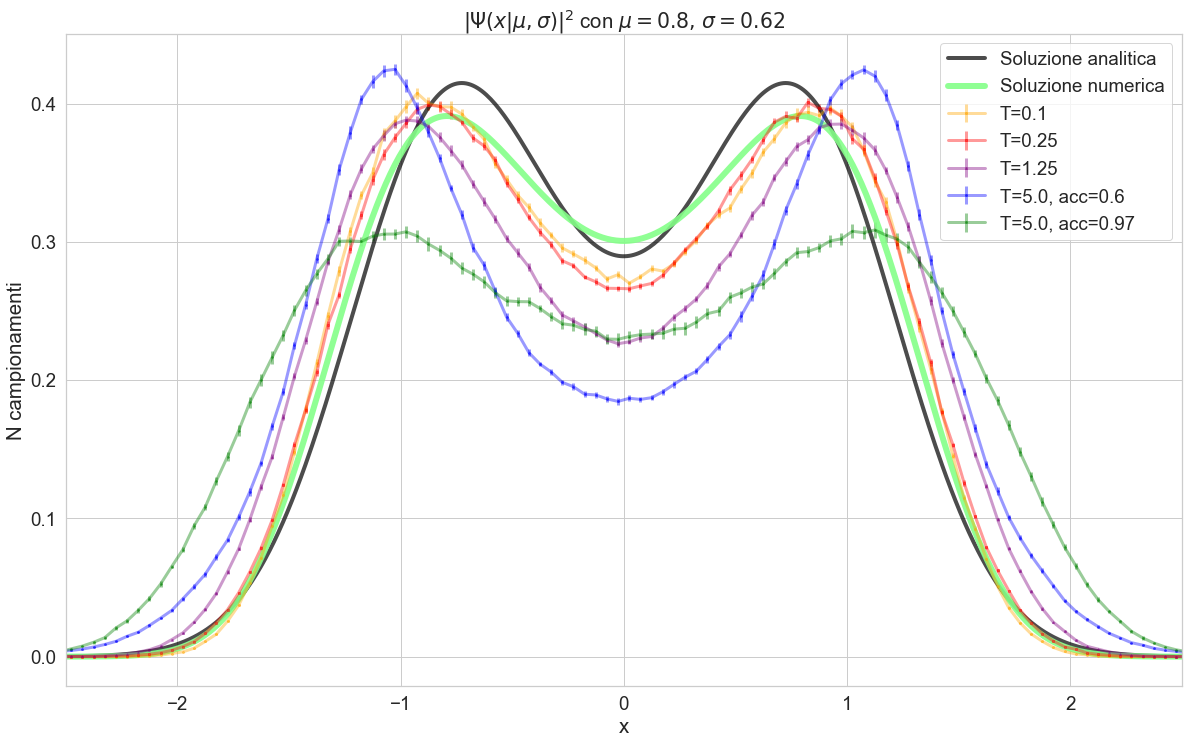

In [155]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.8,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('N campionamenti')


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(len(T)):
    ax.errorbar(pimc_x[i], pimc_p[i], yerr=pimc_e[i], color=color[i], label=labels[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

ax.legend(loc=1)
plt.show()